<a href="https://colab.research.google.com/github/deepankan-rai/DecisionTree-RandomForest/blob/main/DecisionTree_%26_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q graphviz pydotplus

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pydotplus
from IPython.display import Image, display

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

**Load the Dataset and print the shape of the dataset.**

In [5]:
file_path = '/content/heart.csv.xls'
df = pd.read_csv(file_path)

print(f"Loaded dataset from CSV: {file_path}")
print(f"Shape: {df.shape}")
display(df.head())

Loaded dataset from CSV: /content/heart.csv.xls
Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


**Detect target column**

In [6]:
def detect_target(dataframe):
    for name in ['target', 'Target', 'TARGET', 'diagnosis', 'label', 'output', 'HeartDisease', 'hd', 'class']:
        if name in dataframe.columns:
            return name
    for col in dataframe.columns:
        vals = dataframe[col].dropna().unique()
        if len(vals) == 2:
            return col
    return None

target_col = detect_target(df)
if target_col is None:
    raise ValueError("Could not detect a target column. Please set `target_col` manually.")
print("Detected target column:", target_col)

Detected target column: target


**Preprocessing:**
*   Drop constant columns
*   One-hot encode categorical features
*   Impute missing values
*   Scale numerical features

In [7]:
X = df.drop(columns=[target_col])
y = df[target_col]
X = X.loc[:, X.nunique() > 1]
X = pd.get_dummies(X, drop_first=True)

imputer = SimpleImputer(strategy='median')
X[X.columns] = imputer.fit_transform(X[X.columns])
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

print("After preprocessing shape:", X.shape)


After preprocessing shape: (1025, 13)


**Train/test split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

**Decision Tree training & visualization**


Decision Tree - Test accuracy: 0.9853658536585366
Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



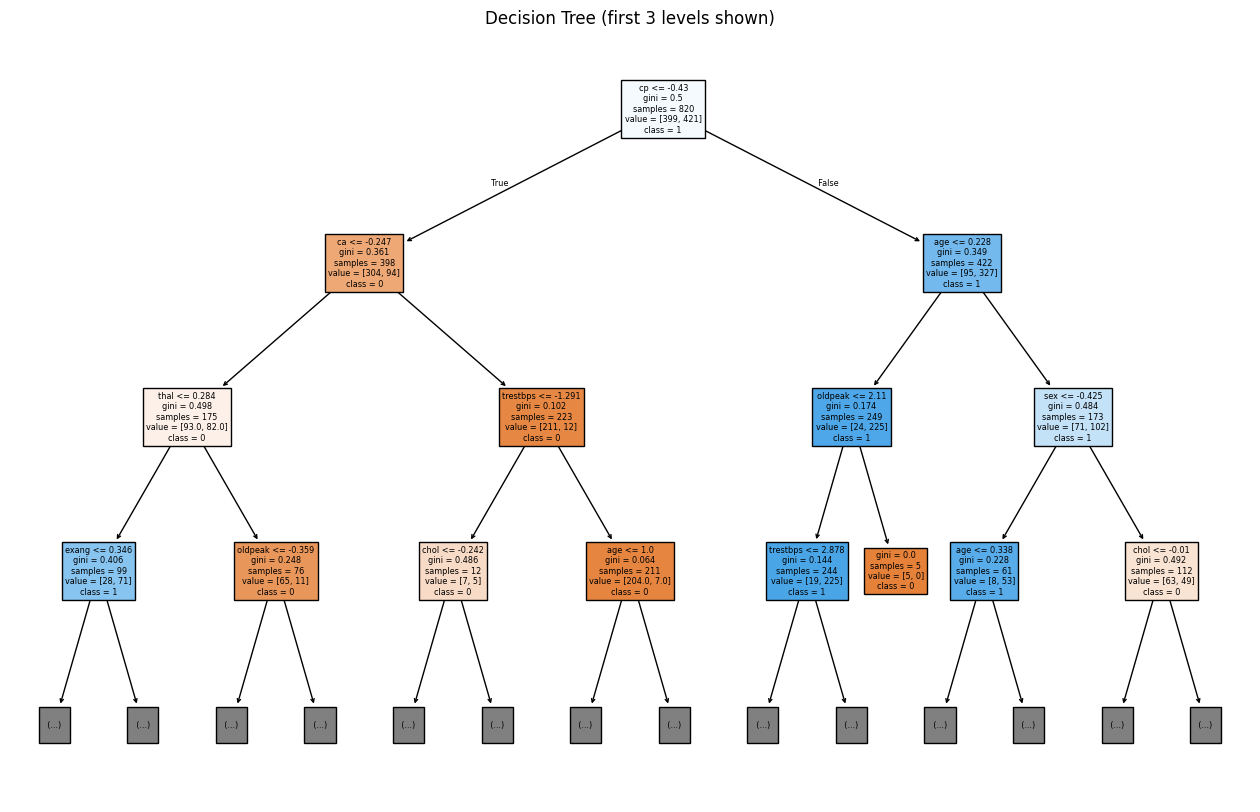

In [9]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print("\nDecision Tree - Test accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(16,10))
plot_tree(dt, feature_names=X.columns, class_names=[str(c) for c in np.unique(y)],
          filled=True, max_depth=3)
plt.title("Decision Tree (first 3 levels shown)")
plt.show()

**Overfitting analysis & Hyperparameter tuning**

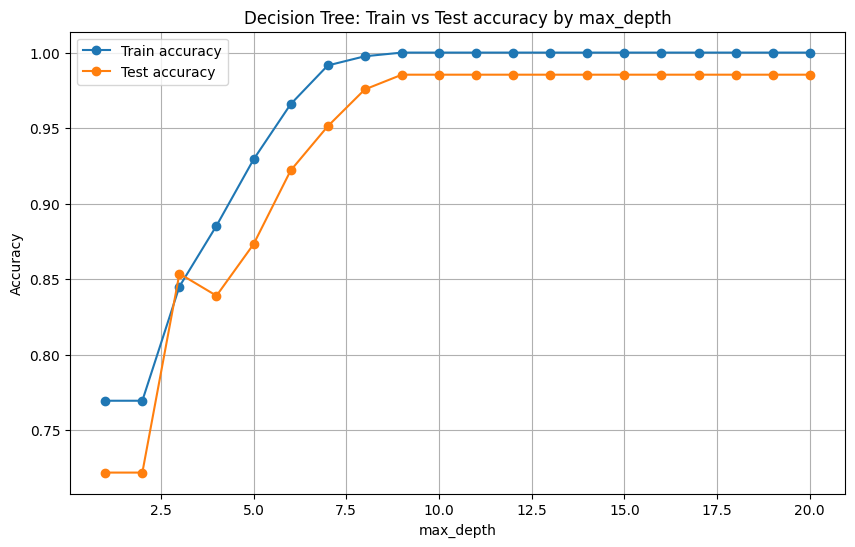

Best Decision Tree params: {'max_depth': 11, 'min_samples_leaf': 1}
Best Decision Tree test accuracy: 0.9853658536585366


In [10]:
depths = list(range(1, 21))
train_scores, test_scores = [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.figure(figsize=(10,6))
plt.plot(depths, train_scores, label='Train accuracy', marker='o')
plt.plot(depths, test_scores, label='Test accuracy', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree: Train vs Test accuracy by max_depth')
plt.legend()
plt.grid(True)
plt.show()

param_grid = {'max_depth': list(range(1, 21)), 'min_samples_leaf': [1,2,4,8]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid,
                  scoring='accuracy', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

best_dt = gs.best_estimator_
y_pred_best = best_dt.predict(X_test)
print("Best Decision Tree params:", gs.best_params_)
print("Best Decision Tree test accuracy:", accuracy_score(y_test, y_pred_best))


**Random Forest training**

In [11]:
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest - Test accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification report:\n", classification_report(y_test, y_pred_rf))



Random Forest - Test accuracy: 1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



Feature importances


Decision Tree (best) feature importances:


,0
cp,0.299922
ca,0.128631
age,0.114920
chol,0.099451
thal,0.079146
oldpeak,0.054481
trestbps,0.051820
thalach,0.043466
slope,0.038558
sex,0.035869


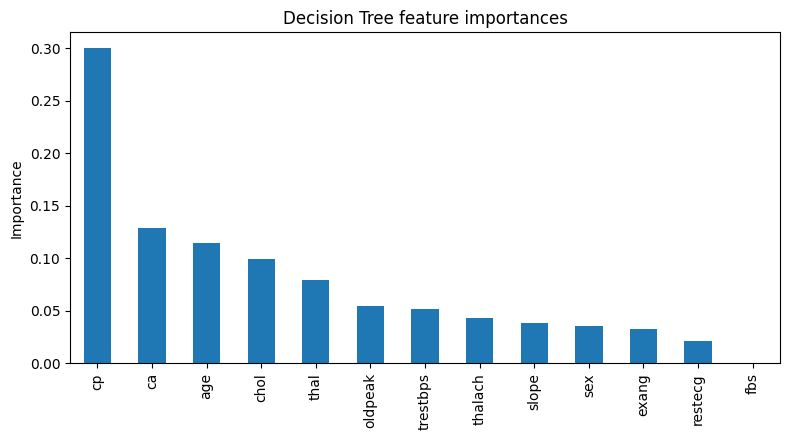


Random Forest feature importances:


,0
cp,0.144796
thalach,0.118097
ca,0.110965
oldpeak,0.105590
thal,0.101825
age,0.091826
chol,0.076579
exang,0.074189
trestbps,0.071178
slope,0.045234


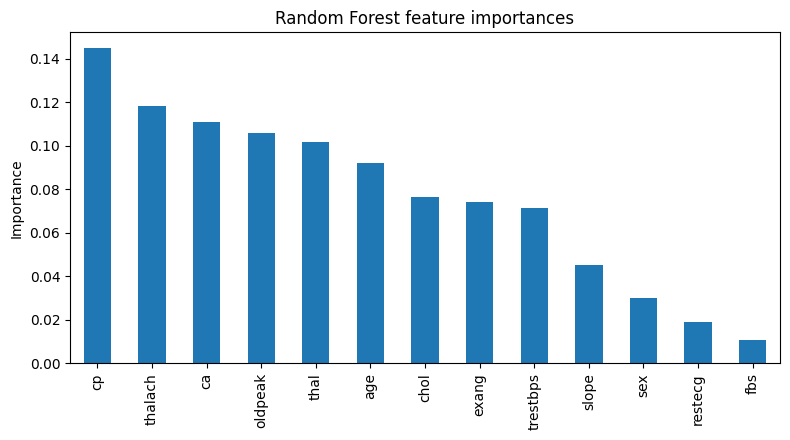

In [12]:
def show_top_features(importances, feature_names, top_n=15, title="Feature importances"):
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    display(fi.head(top_n))
    plt.figure(figsize=(8, max(4, top_n*0.3)))
    fi.head(top_n).plot(kind='bar')
    plt.title(title)
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

print("\nDecision Tree (best) feature importances:")
show_top_features(best_dt.feature_importances_, X.columns, title="Decision Tree feature importances")

print("\nRandom Forest feature importances:")
show_top_features(rf.feature_importances_, X.columns, title="Random Forest feature importances")


**Cross-validation**

In [13]:
dt_cv_scores = cross_val_score(best_dt, X, y, cv=5, scoring='accuracy')
rf_cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

print("Decision Tree CV accuracy: mean={:.4f}, std={:.4f}".format(dt_cv_scores.mean(), dt_cv_scores.std()))
print("Random Forest CV accuracy: mean={:.4f}, std={:.4f}".format(rf_cv_scores.mean(), rf_cv_scores.std()))


Decision Tree CV accuracy: mean=1.0000, std=0.0000
Random Forest CV accuracy: mean=0.9971, std=0.0059
